In [23]:
# Load Python libraries
import sklearn
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

In [39]:
# Load data
df = pd.read_csv('./kkbox/input/train.csv')

# Take 3% sample of items
df = df.sample(frac=0.03)
df.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target
5997458,UFcltK3u/LmkJq5NM9GS/tFHLtFp9qRXO8jxore1YHE=,nBh/12CeQ3B0/CKJw/TrYHJYERGXrfixEOyd3PWBD+k=,listen with,Others profile more,listen-with,0
7105237,l8OntXEd6Ivu2dvfiRhVKjYRY05rWKcekGyBAkVxcVw=,gnegcSj6noIAKWWxM29AvIIadg6p+hn0Iq3BtAVJORM=,search,Artist more,top-hits-for-artist,0
24524,zx51OvMA6lJ+iNxD6lZnUppO8ZKHhuKBIAgGXAObgqQ=,WRuHbl8CJbAuzUb4f/88Ly6IXif+IVVWolkp33Nm8wI=,my library,Local playlist more,local-playlist,1
3693227,dTwJUTcR1/6J4T3Lj+QwLKsswsKpQ0pdTgmCP6mvyxQ=,FV7I/cXgCKXS0d/KsKJ8IMs93HY/psfcwwHqlPPVkBU=,my library,Local playlist more,local-playlist,1
5695985,2Wvn5PUO9n1VPW6ByVKkJZF1T+J5V2s8k2I64mpbvCg=,Xpjwi8UAE2Vv9PZ6cZnhc58MCtl3cKZEO1sdAkqJ4mo=,discover,Search Trends,song,1


* msno: user id
* song_id: song id
* sourcesystemtab: the name of the tab where the event was triggered. System tabs are used to categorize KKBOX mobile apps functions. For example, tab my library contains functions to manipulate the local storage, and tab search contains functions relating to search.
* sourcescreenname: name of the layout a user sees.
* source_type: an entry point a user first plays music on mobile apps. An entry point could be album, online-playlist, song .. etc.
* target: this is the target variable. target=1 means there are recurring listening event(s) triggered within a month after the user’s very first observable listening event, target=0 otherwise .

In [25]:
# Load songs data and join the data with df
songs = pd.read_csv('./kkbox/input/songs.csv')
df = pd.merge(df, songs, on='song_id', how='left')
del songs

# Load members data and join the data with df
members = pd.read_csv('./kkbox/input/members.csv')
df = pd.merge(df, members, on='msno', how='left')
del members

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 221323 entries, 0 to 221322
Data columns (total 18 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   msno                    221323 non-null  object 
 1   song_id                 221323 non-null  object 
 2   source_system_tab       220584 non-null  object 
 3   source_screen_name      208834 non-null  object 
 4   source_type             220697 non-null  object 
 5   target                  221323 non-null  int64  
 6   song_length             221317 non-null  float64
 7   genre_ids               217710 non-null  object 
 8   artist_name             221317 non-null  object 
 9   composer                171314 non-null  object 
 10  lyricist                125963 non-null  object 
 11  language                221317 non-null  float64
 12  city                    221323 non-null  int64  
 13  bd                      221323 non-null  int64  
 14  gender              

* bd: age. Note: this column has outlier values ranging from -7000 to 2015, please use your judgement.
* registered_via: registration method
* registration_init_time: format %Y%m%d
* expiration_date: format %Y%m%d, taken as a snapshot at which the member.csv is extracted. Not representing the actual churn behavior.
* genre_ids: genre category. Some songs have multiple genres and they are separated by |

In [27]:
# Count Na in %
df.isnull().sum()/df.isnull().count()*100

msno                       0.000000
song_id                    0.000000
source_system_tab          0.333901
source_screen_name         5.642884
source_type                0.282845
target                     0.000000
song_length                0.002711
genre_ids                  1.632456
artist_name                0.002711
composer                  22.595483
lyricist                  43.086349
language                   0.002711
city                       0.000000
bd                         0.000000
gender                    40.155790
registered_via             0.000000
registration_init_time     0.000000
expiration_date            0.000000
dtype: float64

In [28]:
# Replace NA
for i in df.select_dtypes(include=['object']).columns:
    df[i][df[i].isnull()] = 'unknown'
df = df.fillna(value=0)

In [29]:
# Create Dates

# registration_init_time
df.registration_init_time = pd.to_datetime(df.registration_init_time, format='%Y%m%d', errors='ignore')
df['registration_init_time_year'] = df['registration_init_time'].dt.year
df['registration_init_time_month'] = df['registration_init_time'].dt.month
df['registration_init_time_day'] = df['registration_init_time'].dt.day

# expiration_date
df.expiration_date = pd.to_datetime(df.expiration_date,  format='%Y%m%d', errors='ignore')
df['expiration_date_year'] = df['expiration_date'].dt.year
df['expiration_date_month'] = df['expiration_date'].dt.month
df['expiration_date_day'] = df['expiration_date'].dt.day

In [30]:
df.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,...,gender,registered_via,registration_init_time,expiration_date,registration_init_time_year,registration_init_time_month,registration_init_time_day,expiration_date_year,expiration_date_month,expiration_date_day
0,zIVDNYrxuU1XALBSVZtZgwSWFK3ds3Ac9Egoy2h4304=,OrYdxT0jW/+UUMI076UtHPSGVO4/hnKAWuYXQ+45Kj8=,my library,Local playlist more,local-library,1,311797.0,465,蕭亞軒 (Elva Hsiao),unknown,...,female,3,2015-05-08,2017-09-16,2015,5,8,2017,9,16
1,o/JiK991zGFPWZUpffnWADsNFopLfdSG0rwFsUBkUpk=,rs6vr0QtClmnuXvsrzW7wM8ciWbPlN/5ObPu5N6LLRQ=,my library,Local playlist more,local-library,1,194652.0,465,PSY,unknown,...,female,3,2012-06-10,2017-09-25,2012,6,10,2017,9,25
2,Kup6VNdSWBeGmKcPDcwHFrAQeA7yTaLLwTh0PJxTZUg=,FAGiY4iJYofxEiSXK5/KRFQUsAC8tGxPIcYweJ413I0=,discover,Online playlist more,online-playlist,0,230086.0,444,SANDEUL,unknown,...,unknown,7,2015-09-02,2017-10-02,2015,9,2,2017,10,2
3,6o0lI2nTD7bDTr3jnTXo0twNqommX9h18GLJoS41PuI=,8cKv2f3LBMarqBNHSSDYXd9fzc05giVlcu/Vj3GjFFM=,listen with,Online playlist more,online-playlist,1,196440.0,458,A-Lin,宋唯農/曹俊鴻,...,unknown,7,2011-06-14,2017-08-01,2011,6,14,2017,8,1
4,Xa3bbIsP+DO7sQdTiljlnXoiRJl6JXU5xDe9y3HG6Lc=,rjkuGJ4yhxfmN/u5Y04zT85foSCtu9TSH4DopXHW4xw=,radio,Radio,radio,0,266379.0,465,Simon Webbe,Simon Webbe| Tim Woodcock| Matt Prime,...,male,9,2015-07-05,2018-01-11,2015,7,5,2018,1,11


In [31]:
# Dates to categoty
df['registration_init_time'] = df['registration_init_time'].astype('category')
df['expiration_date'] = df['expiration_date'].astype('category')

In [32]:
# Object data to category
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].astype('category')
    
# Encoding categorical features
for col in df.select_dtypes(include=['category']).columns:
    df[col] = df[col].cat.codes

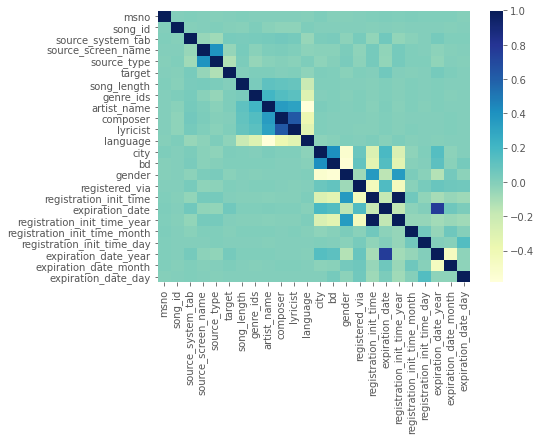

In [37]:
# Сorrelation matrix
plt.figure(figsize=[7,5])
sns.heatmap(df.corr(), cmap="YlGnBu")
plt.show()

In [12]:
# Drop columns
df = df.drop(['expiration_date', 'lyricist', 'gender'], 1)

In [13]:
# Model with the best estimator
model = RandomForestClassifier(n_estimators=250, max_depth=25)
model.fit(df[df.columns[df.columns != 'target']], df.target)

RandomForestClassifier(max_depth=25, n_estimators=250)

In [14]:
df_plot = pd.DataFrame({'features': df.columns[df.columns != 'target'],
                        'importances': model.feature_importances_})
df_plot = df_plot.sort_values('importances', ascending=False)

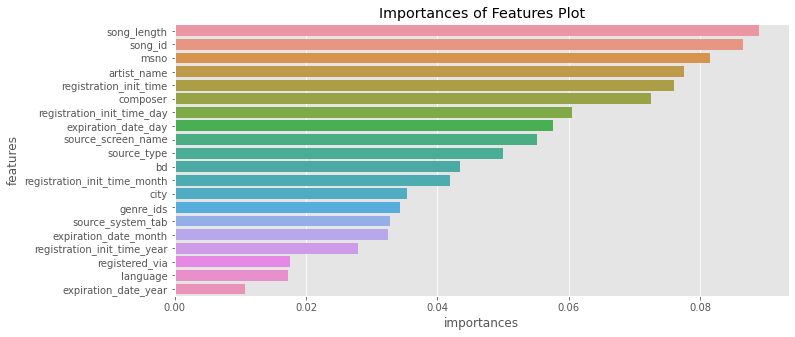

In [15]:
plt.figure(figsize=[11,5])
sns.barplot(x = df_plot.importances, y = df_plot.features)
plt.title('Importances of Features Plot')
plt.show()

In [16]:
# Drop columns with importances < 0.04
df = df.drop(df_plot.features[df_plot.importances < 0.04].tolist(), 1)

In [17]:
# Selected columns
df.columns

Index(['msno', 'song_id', 'source_screen_name', 'source_type', 'target',
       'song_length', 'artist_name', 'composer', 'bd',
       'registration_init_time', 'registration_init_time_month',
       'registration_init_time_day', 'expiration_date_day'],
      dtype='object')

In [18]:
# Train & Test split
target = df.pop('target')
train_data, test_data, train_labels, test_labels = sklearn.model_selection.train_test_split(df, target, test_size = 0.3)

# Delete df
del df

In [19]:
# Create model
model = xgb.XGBClassifier(learning_rate=0.1, max_depth=15, min_child_weight=5, n_estimators=250)
model.fit(train_data, train_labels)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=15,
              min_child_weight=5, missing=nan, monotone_constraints='()',
              n_estimators=250, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [20]:
# Predicting
predict_labels = model.predict(test_data)

In [21]:
print(sklearn.metrics.classification_report(test_labels, predict_labels))

              precision    recall  f1-score   support

           0       0.65      0.62      0.63     32965
           1       0.64      0.67      0.65     33432

    accuracy                           0.64     66397
   macro avg       0.64      0.64      0.64     66397
weighted avg       0.64      0.64      0.64     66397

